In [1]:
#from statsmodels.tsa.arima_process import ArmaProcess 
#from statsmodels.tsa.stattools import pacf, acf
#from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

Could not import rpy package
Could not import r-package RCIT


In [6]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

In [7]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [8]:
def color_map(lst, cmap):
    result = []
    minima = min(lst)
    maxima = max(lst)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    c = mapper.to_rgba(lst)
    
    for i in range(len(lst)):
        result.append('#{:02x}{:02x}{:02x}{:02x}'.format(int(c[i,0]*255), int(c[i,1]*255) , int(c[i,2]*255), int(c[i,3]*255)))
        
    return(result)

In [9]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [10]:
def neighbour_vote(df,lat,lon):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if not df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values.size == 0:           
            result.append(np.asscalar(df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values))
        else:
            result.append(-1)   
            
        
    return(np.array(result))

In [11]:
def neighbour_vote_class(dic,lat,lon):
    shift = [[-0.25,0.25],[-0.25,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    #shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if lon > 180: lon -= 360
        if (lat + y, lon + x) in class_dic.keys():
            result.append(class_dic[(lat + y, lon + x)])   
    return(np.array(result))

In [15]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1946, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [10]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        #if not np.isnan(data[i,j,-1]):
        if not data[i,j,-1]<0:    
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

FileNotFoundError: [Errno 2] No such file or directory: 'data.npy'

In [102]:
d = Data('../precipitation.nc','precip',temporal_limits,missing_value=-9.969209968386869e+36)

result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [103]:
result = pf.deseasonalize(np.array(result))

In [81]:
result = pd.DataFrame(result)

In [238]:
d = result[360]

In [239]:
d = pd.DataFrame(d)

scale = StandardScaler()
d = scale.fit_transform(d)

In [240]:
result = np.array(result)

# PCA

In [104]:
result = pf.deseasonalize(np.array(result))
data = pd.DataFrame(result)


scale = StandardScaler()
scaled_data = scale.fit_transform(data)

pca = PCA(n_components=n_components)
pca_model = pca.fit(scaled_data)

df_cluster = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_sst = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
loading = loading/loading.sum()

clusters = loading.idxmax(axis=1)
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clusters.values.tolist()})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"].vlues = lon_temp

In [105]:
df_pca = pd.DataFrame(df_cluster)
df_pca.to_csv("cluser_pca.csv")

# Clustering

In [35]:
temp = np.array(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

In [36]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

In [37]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [38]:
clusters = clustering.labels_

In [218]:
df.iloc[391,]

lons        31.25
lats        18.75
clusters     1.00
Name: 391, dtype: float64

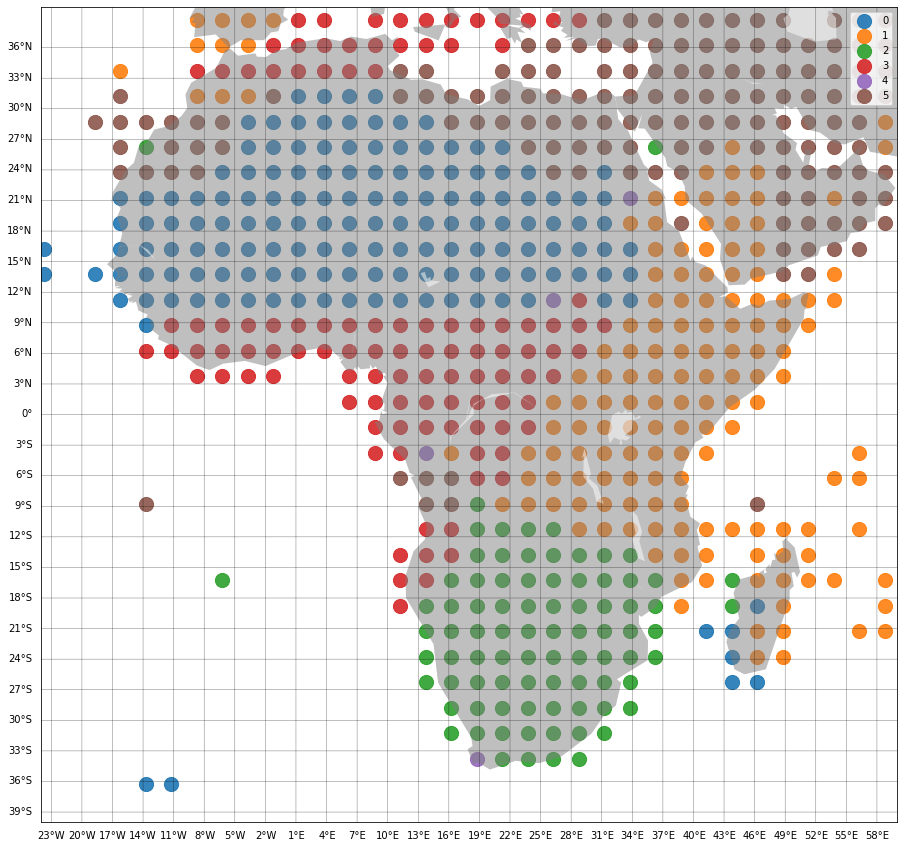

In [83]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

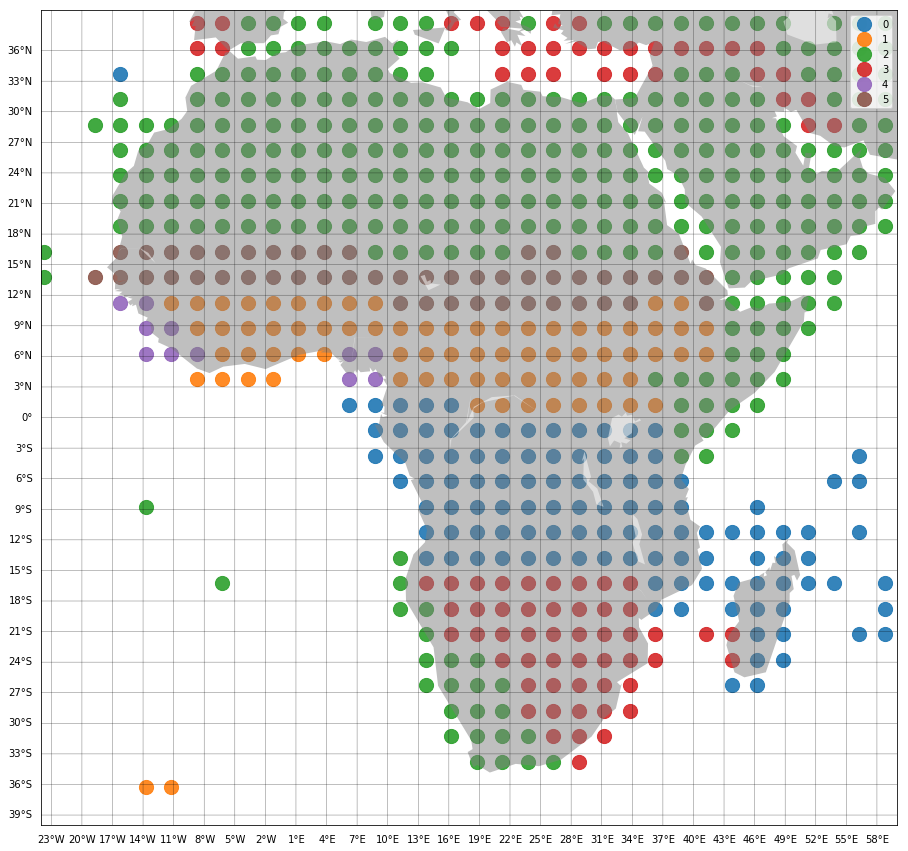

In [36]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

# PCA for each clusters

In [76]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

In [89]:
df_cluster = pd.DataFrame(np.transpose(np.array(cluster_data)))

#scale = StandardScaler()
#df_cluster = scale.fit_transform(df_cluster)
#df_cluster = pd.DataFrame(np.transpose(cluster_data))

In [72]:
df_cluster = (df_cluster - df_cluster.mean())/ df_cluster.std()

In [78]:
df_cluster.to_csv("clusters.csv")

In [19]:
pca_model.explained_variance_ratio_

array([0.17373752, 0.08434206, 0.06579084, 0.04961569, 0.0405939 ,
       0.03564976])

In [91]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [92]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 7 link(s):
        (3 0): pval = 0.00000 | val = 0.289
        (4 0): pval = 0.00000 | val = 0.269
        (2 0): pval = 0.00000 | val = 0.219
        (0 -1): pval = 0.00003 | val = 0.144
        (1 -1): pval = 0.00357 | val = 0.101
        (5 0): pval = 0.02021 | val = 0.081
        (1 0): pval = 0.02578 | val = 0.077

    Variable 1 has 4 link(s):
        (1 -1): pval = 0.00000 | val = 0.215
        (3 -1): pval = 0.00701 | val = -0.094
        (2 -2): pval = 0.01444 | val = -0.085
        (0 0): pval = 0.02578 | val = 0.077

    Variable 2 has 7 link(s):
        (5 0): pval = 0.00000 | val = 0.346
        (4 0): pval = 0.00000 | val = 0.323
        (2 -1): pval = 0.00000 | val = 0.295
        (0 0): pval = 0.00000 | val = 0.219
        (5 -1): pval = 0.00039 | val = -0.123
        (3 0): pval = 0.00202 | val = 0.107
        (4 -2): pval = 0.02925 | val = -0.076

    Variable 3 has 6 link(s):
        (3 -1): pval = 0.00000 | 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2775ae9940>)

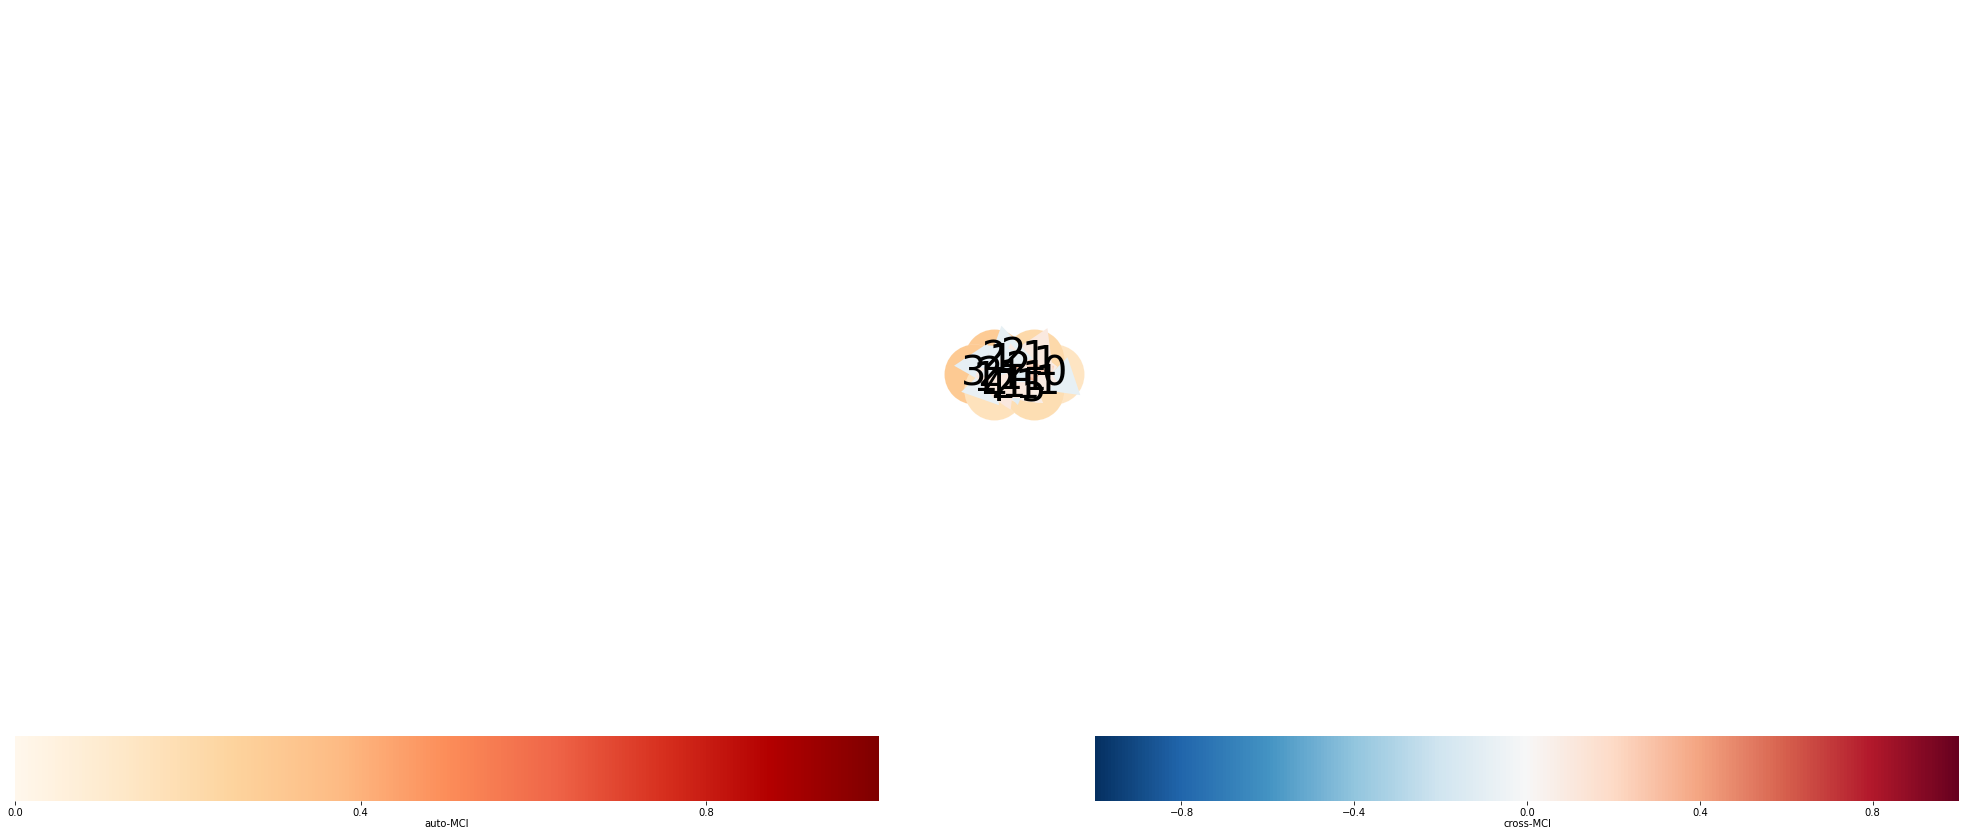

In [93]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [95]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 4 link(s):
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.289
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.269
        (2 0): pval = 0.00000 | qval = 0.00000 | val = 0.219
        (0 -1): pval = 0.00003 | qval = 0.00035 | val = 0.144

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.215

    Variable 2 has 6 link(s):
        (5 0): pval = 0.00000 | qval = 0.00000 | val = 0.346
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.323
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.295
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.219
        (5 -1): pval = 0.00039 | qval = 0.00399 | val = -0.123
        (3 0): pval = 0.00202 | qval = 0.00202 | val = 0.107

    Variable 3 has 3 link(s):
        (3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.304
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.289
        (2 0): pval = 0.00202 | qval =

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f277657db70>)

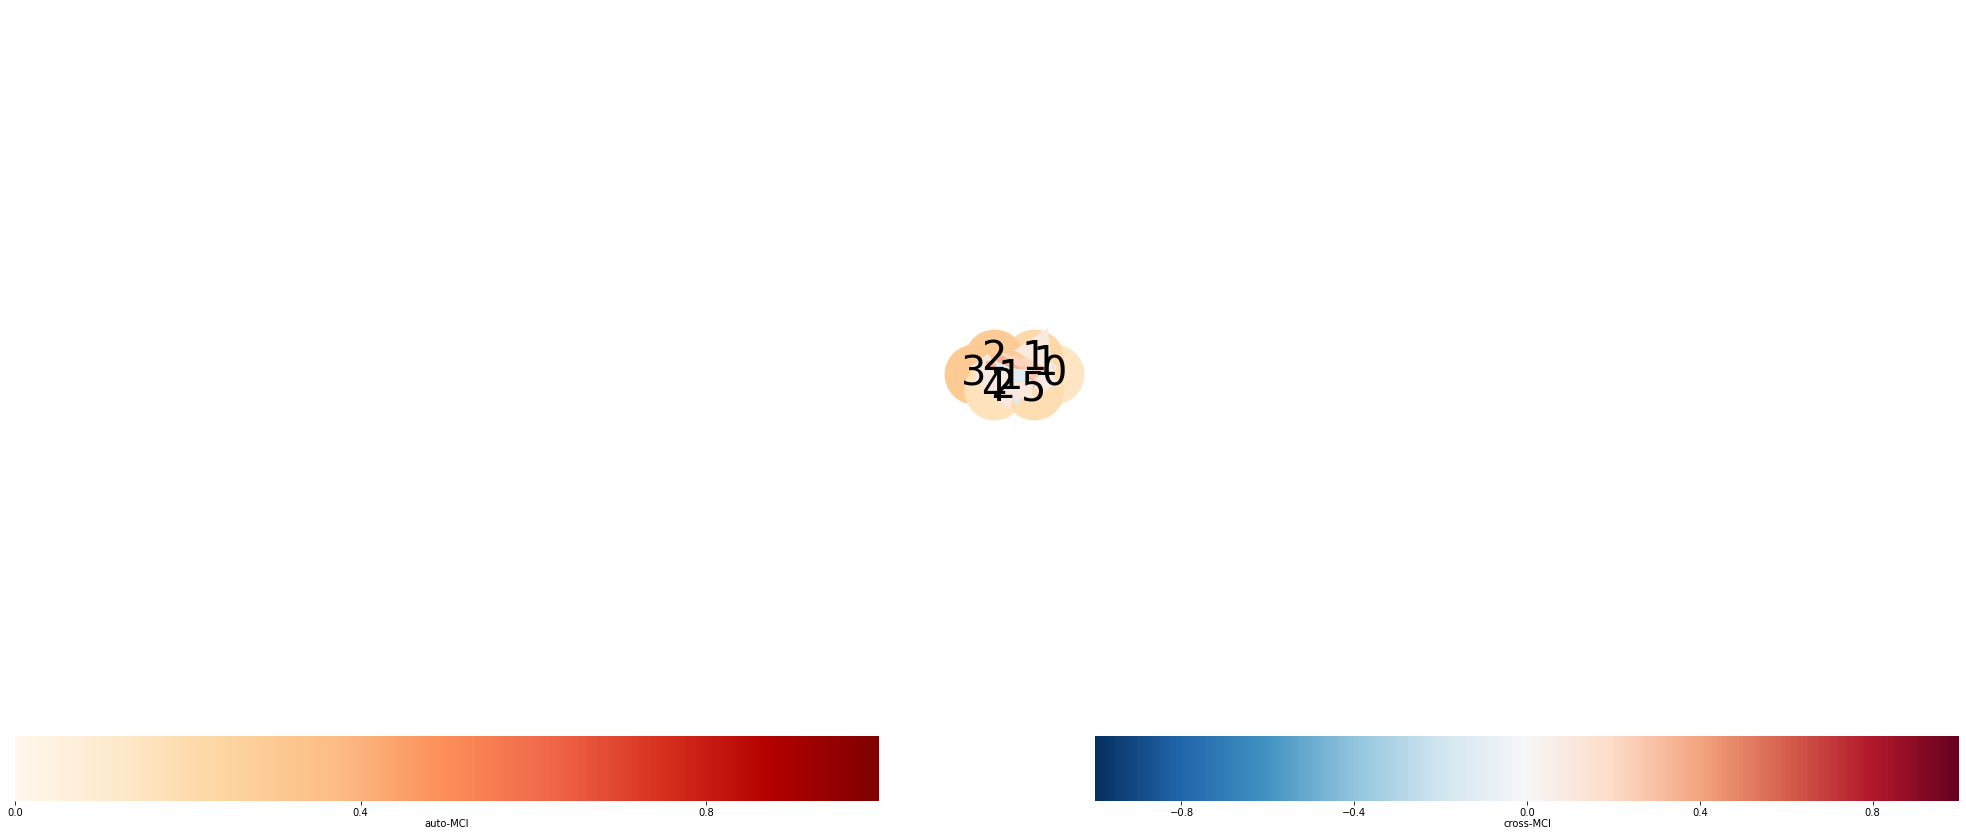

In [46]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [61]:
ET_gamma = np.load("ET_pearson.npy")
N = ET_gamma.shape[0]
n_nodes = ET_gamma.shape[1]
extremes_treshold = -1
count = []
for i in range(N):
    count.append(np.count_nonzero(ET_gamma[i,:] <= extremes_treshold))

In [62]:
n_components = 6
level = 12
temporal_limits = {"time_min":datetime(1977, 1, 1, 0, 0),"time_max":datetime(2015, 12, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

# Adding SST

In [20]:
sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))
data_sst = pd.DataFrame(result_sst)

#result_sst = pf.deseasonalize(np.array(result_sst))
n_components_sst = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(scaled_data)

df_cluster_sst = pca_model.transform(data_sst)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_sst = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [63]:
count_name  = ["count"]

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

#
var_names = count_name + sst_name

In [64]:
result_d = np.array(count)
result_d = result_d.reshape((len(count),1))
result_sst = np.matrix(df_cluster_sst)

result = np.concatenate((result_d, result_sst,), axis=1)
result = np.matrix(result)

#result = pd.DataFrame(result)

In [65]:
#result.to_csv("df_cluster.csv")

dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)


## Significant links at alpha = 0.01:

    Variable count has 4 link(s):
        (count -1): pval = 0.00000 | val = 0.661
        (SST_6 -2): pval = 0.00056 | val = -0.162
        (SST_19 -1): pval = 0.00056 | val = -0.162
        (SST_11 -1): pval = 0.00957 | val = -0.122

    Variable SST_0 has 5 link(s):
        (SST_0 -1): pval = 0.00000 | val = 0.626
        (SST_9 0): pval = 0.00038 | val = -0.167
        (SST_10 0): pval = 0.00044 | val = 0.165
        (SST_4 -1): pval = 0.00529 | val = 0.131
        (SST_19 0): pval = 0.00848 | val = 0.124

    Variable SST_1 has 3 link(s):
        (SST_1 -1): pval = 0.00000 | val = 0.707
        (SST_7 0): pval = 0.00000 | val = -0.239
        (SST_1 -2): pval = 0.00671 | val = -0.127

    Variable SST_2 has 3 link(s):
        (SST_2 -1): pval = 0.00000 | val = 0.727
        (SST_8 0): pval = 0.00000 | val = 0.249
        (SST_10 0): pval = 0.00423 | val = 0.135

    Variable SST_3 has 5 link(s):
        (SST_3 -1): pval = 0.00000 | val = 0.6

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe6962d3438>)

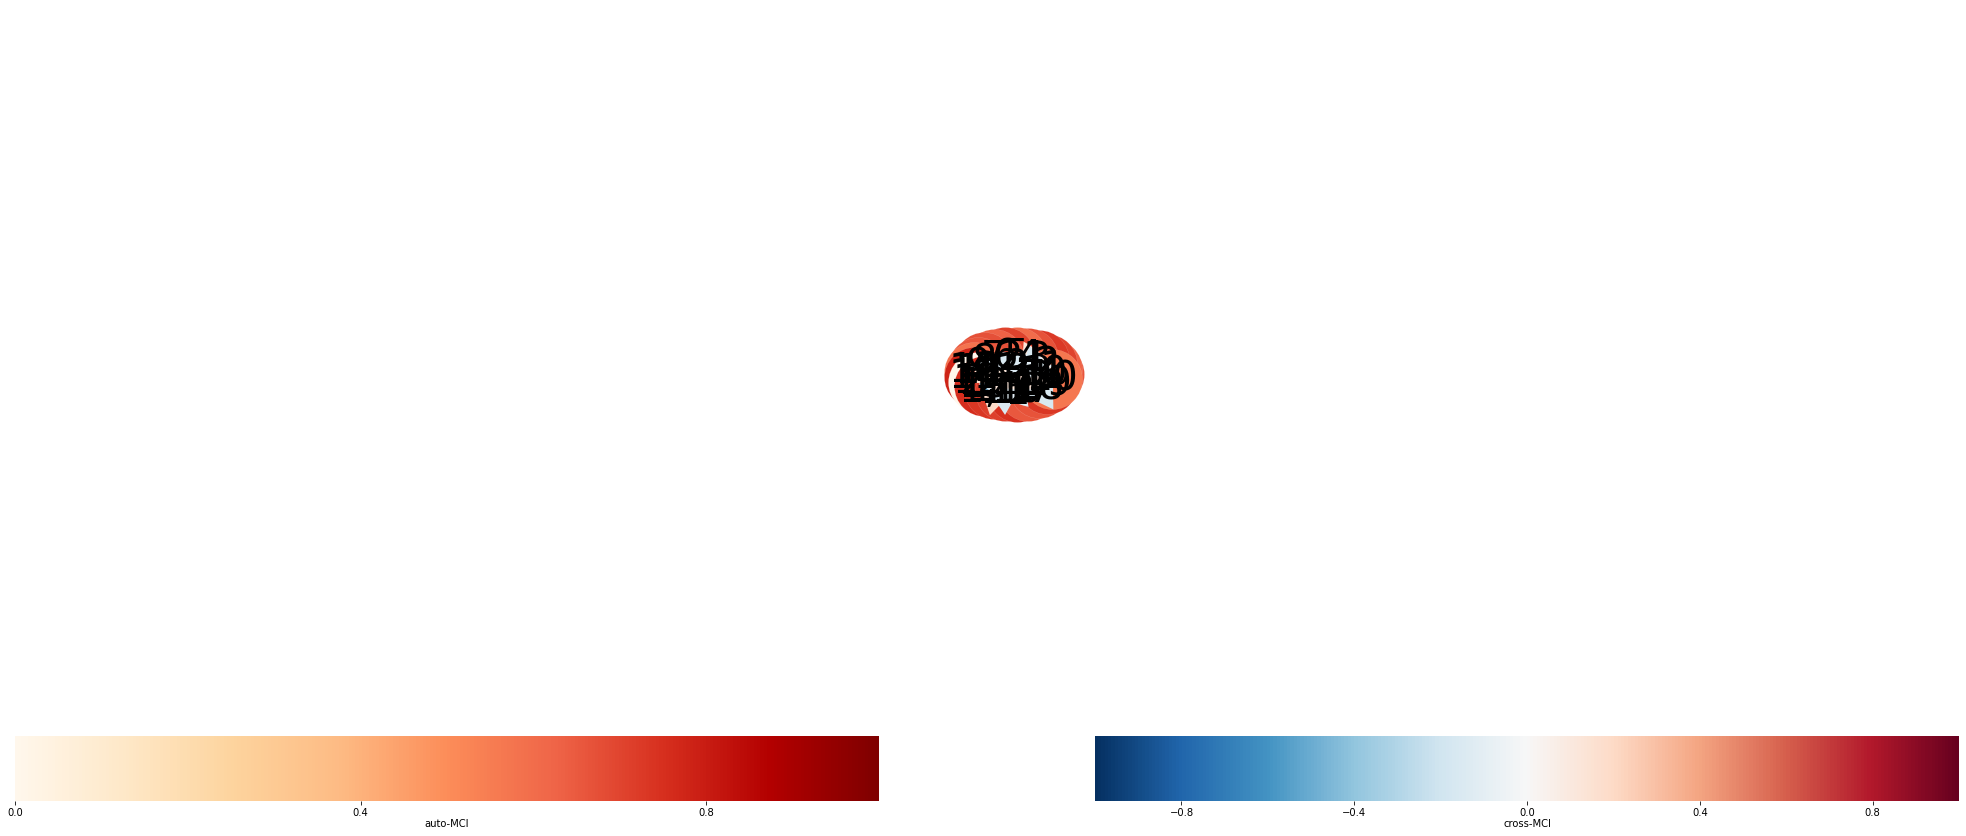

In [66]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)

link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe69d292cc0>)

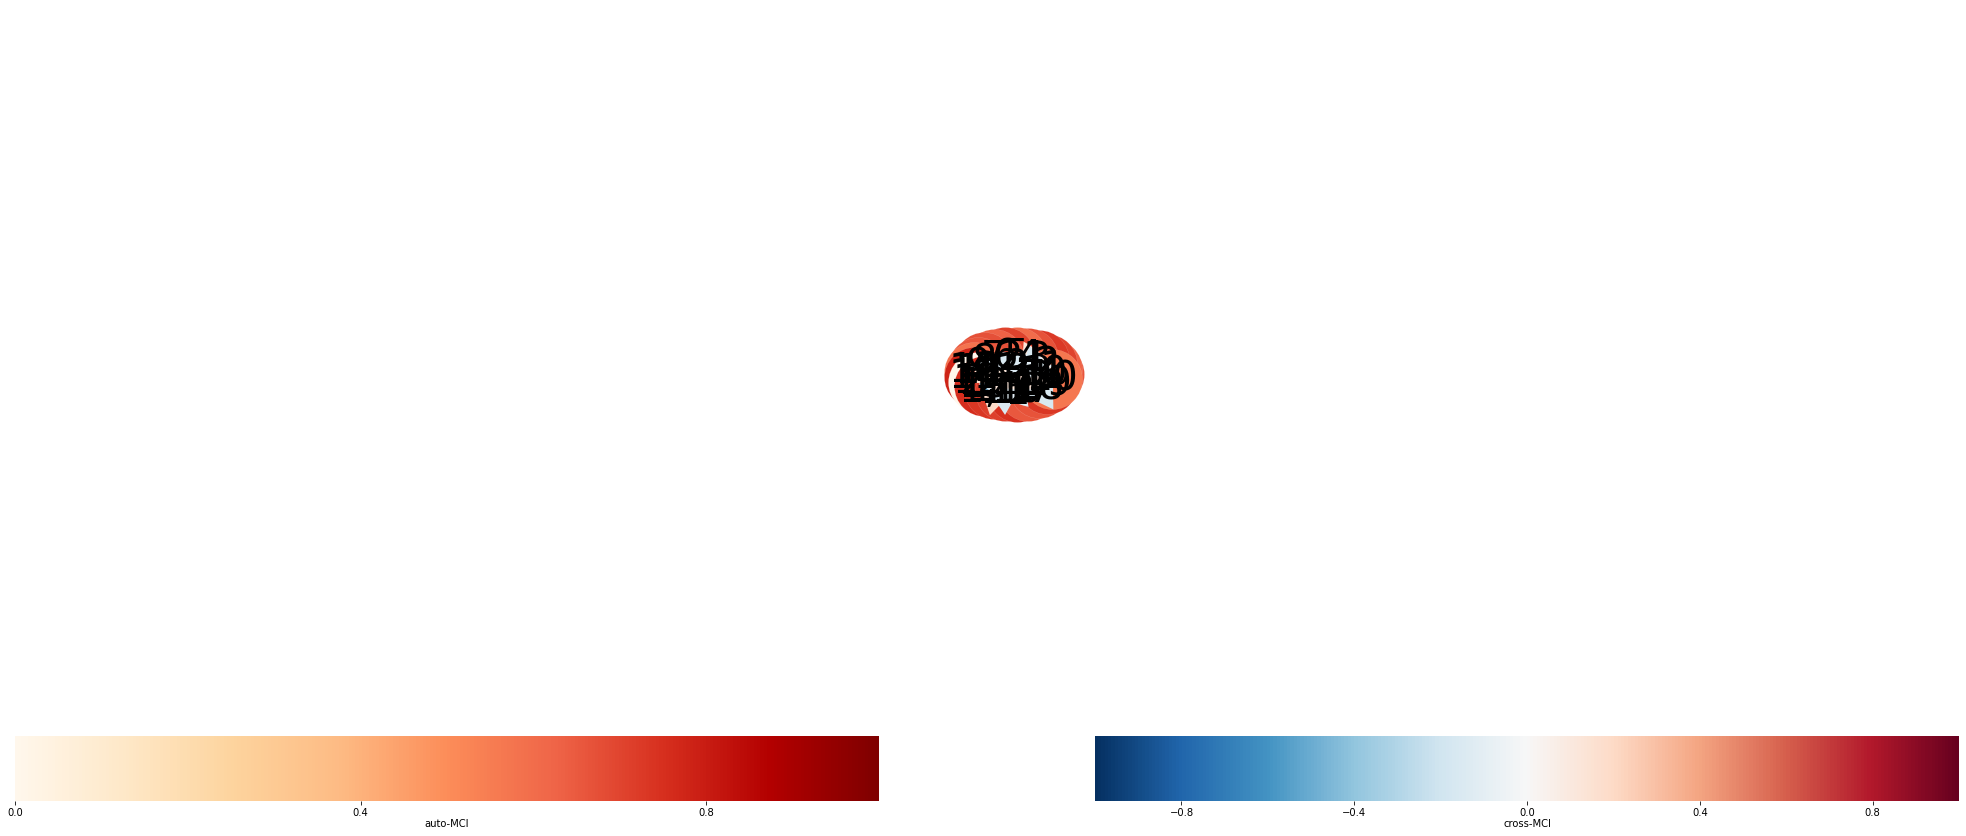

In [67]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

In [68]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable count has 1 link(s):
        (count -1): pval = 0.00000 | qval = 0.00000 | val = 0.661

    Variable SST_0 has 4 link(s):
        (SST_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.626
        (SST_9 0): pval = 0.00038 | qval = 0.00038 | val = -0.167
        (SST_10 0): pval = 0.00044 | qval = 0.00044 | val = 0.165
        (SST_19 0): pval = 0.00848 | qval = 0.00848 | val = 0.124

    Variable SST_1 has 2 link(s):
        (SST_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.707
        (SST_7 0): pval = 0.00000 | qval = 0.00000 | val = -0.239

    Variable SST_2 has 3 link(s):
        (SST_2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.727
        (SST_8 0): pval = 0.00000 | qval = 0.00000 | val = 0.249
        (SST_10 0): pval = 0.00423 | qval = 0.00423 | val = 0.135

    Variable SST_3 has 4 link(s):
        (SST_3 -1): pval = 0.00000 | qval = 0.00000 | val = 0.669
        (SST_14 0): pval = 0.00356 | qval = 0.00356 | val = -

In [ ]:




link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

# Adding SST (Clustering)

In [60]:
n_components_sst = 20

sst = Data('../../nc/sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_sst)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

cluster_sst = []
for i in range(n_components_sst):
    Idx = np.where((df_sst.clusters == i).values)[0]
    r = result_sst[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_sst)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_sst.append(pca_data[:,0])

df_cluster_sst = pd.DataFrame(np.transpose(np.matrix(cluster_sst)))

scale = StandardScaler()
df_cluster_sst = scale.fit_transform(df_cluster_sst)

In [77]:
import matplotlib
import matplotlib.cm as cm

lst = np.arange(0,18,1)

minima = min(lst)
maxima = max(lst)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys_r)

for v in lst:
    print(mapper.to_rgba(v))

(0.0, 0.0, 0.0, 1.0)
(0.06828143021914648, 0.06828143021914648, 0.06828143021914648, 1.0)
(0.13656286043829297, 0.13656286043829297, 0.13656286043829297, 1.0)
(0.21776239907727796, 0.21776239907727796, 0.21776239907727796, 1.0)
(0.3008073817762399, 0.3008073817762399, 0.3008073817762399, 1.0)
(0.36724336793540946, 0.36724336793540946, 0.36724336793540946, 1.0)
(0.42814302191464815, 0.42814302191464815, 0.42814302191464815, 1.0)
(0.49134948096885817, 0.49134948096885817, 0.49134948096885817, 1.0)
(0.5559400230680508, 0.5559400230680508, 0.5559400230680508, 1.0)
(0.6242214532871972, 0.6242214532871972, 0.6242214532871972, 1.0)
(0.6961937716262976, 0.6961937716262976, 0.6961937716262976, 1.0)
(0.7605536332179931, 0.7605536332179931, 0.7605536332179931, 1.0)
(0.8122260668973471, 0.8122260668973471, 0.8122260668973471, 1.0)
(0.8615916955017301, 0.8615916955017301, 0.8615916955017301, 1.0)
(0.9040369088811995, 0.9040369088811995, 0.9040369088811995, 1.0)
(0.9446366782006921, 0.94463667820069

ValueError: Colormap Set1lk is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

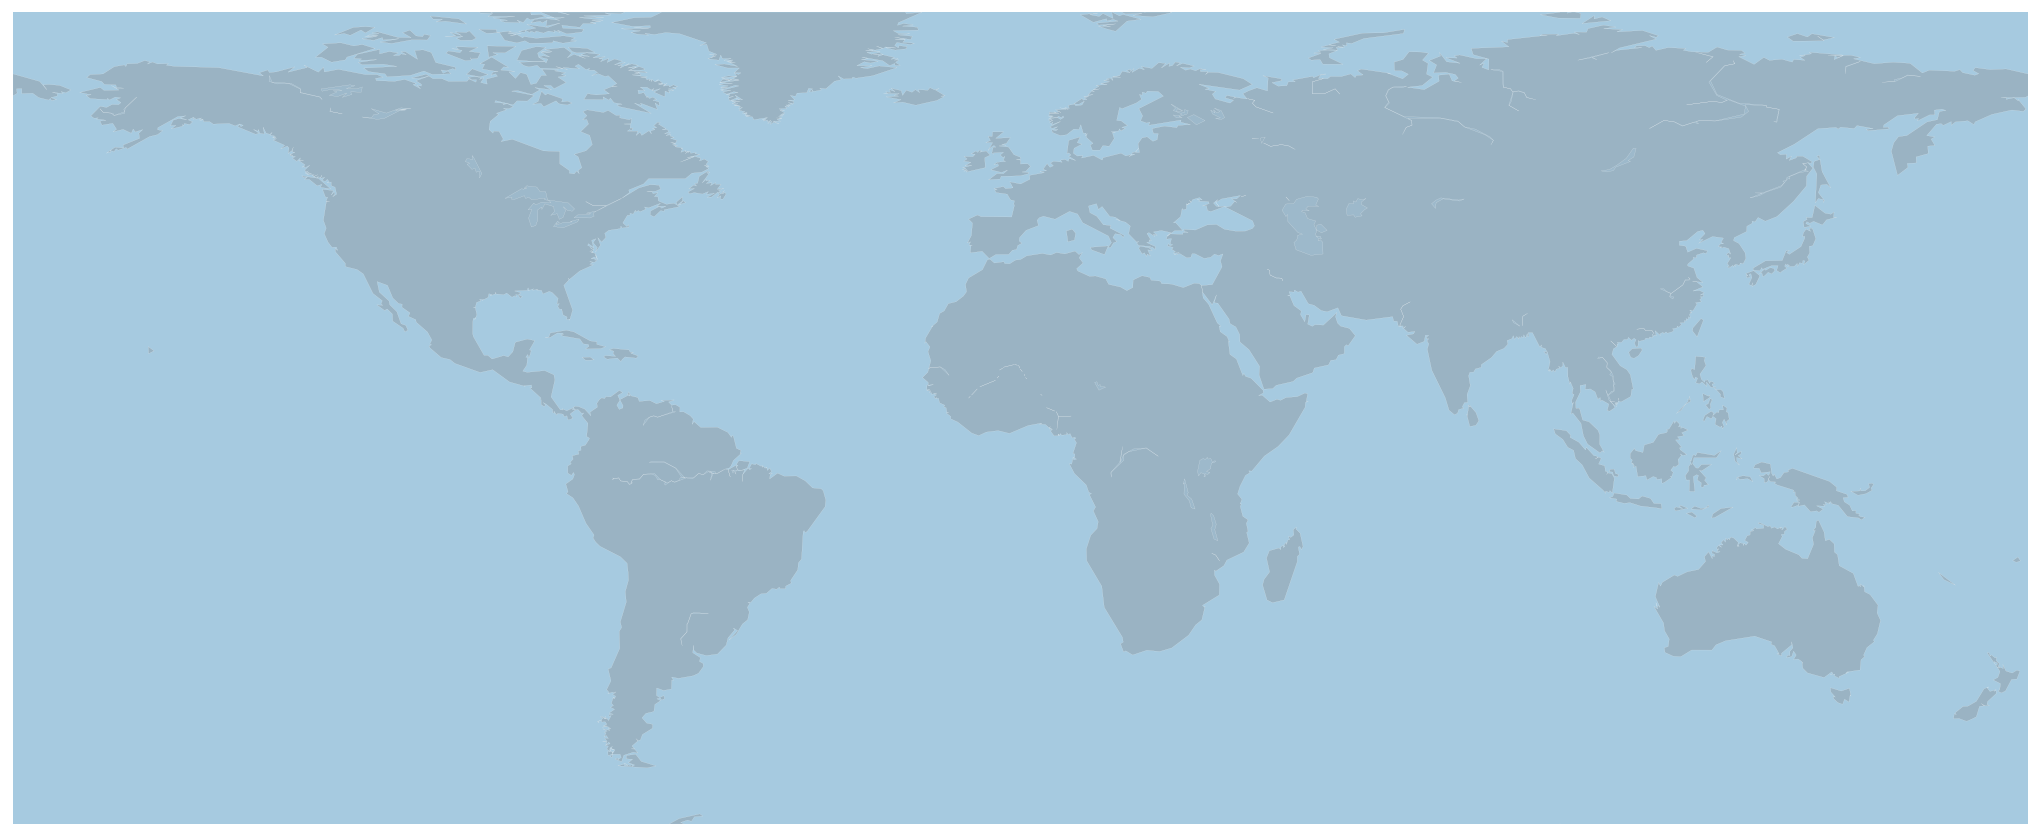

In [78]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
 
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
# read the data (on the web)
#data = pd.read_csv('http://python-graph-gallery.com/wp-content/uploads/TweetSurfData.csv', sep=";")
 
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
#df_sst['labels_enc'] = pd.factorize(data['homecontinent'])[0]
 
# Add a point per position
m.scatter(df_sst['lons'], df_sst['lats'], s=30, alpha=0.4, c=df_sst['clusters'], cmap="Set1lk")
 
# copyright and source data info
#plt.text( -170, -58,'Where people talk about #Surf\n\nData collected on twitter by @R_Graph_Gallery during 300 days\nPlot realized with Python and the Basemap library', ha='left', va='bottom', size=9, color='#555555' )
 
# Save as png
#plt.savefig('#315_Tweet_Surf_Bubble_map1.png', bbox_inches='tight')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#for a in [100, 300, 500]:
#    plt.scatter([], [], c='k', alpha=0.5, s=a,
#                label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left');

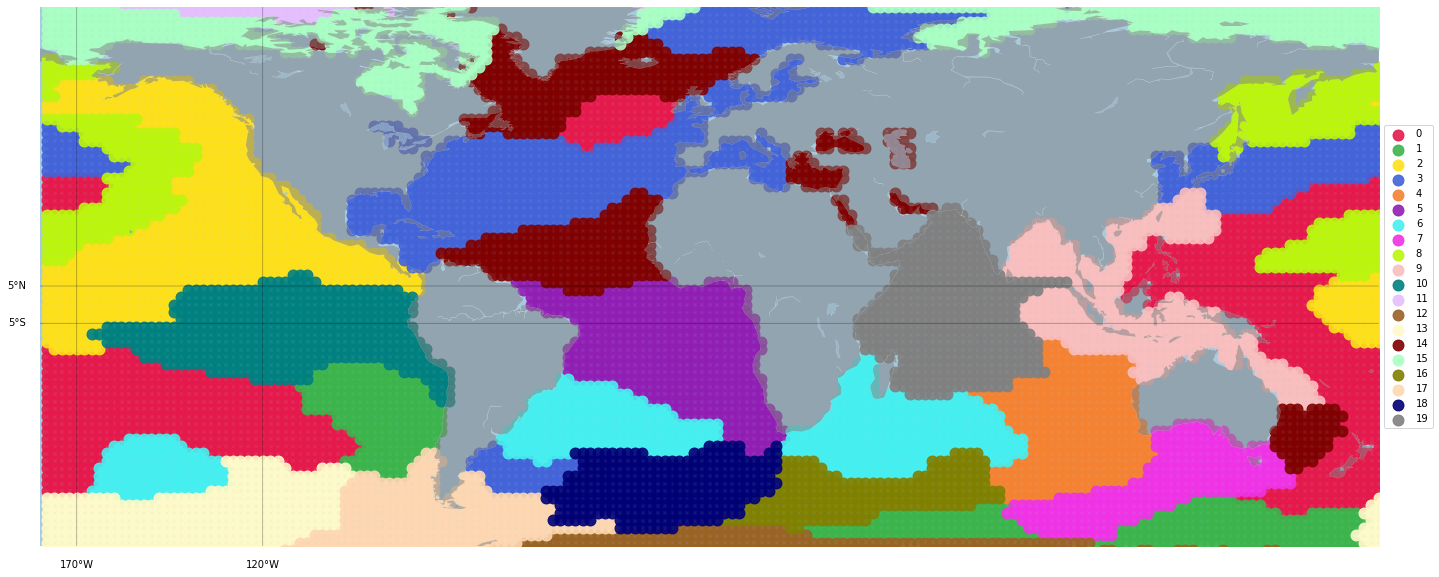

In [69]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawparallels(np.arange(int(-5),int(10),10),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-170),int(-80),50),labels=[0,0,0,1],linewidth=0.5)

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', 
#'#3690c0', '#0570b0', '#045a8d', '#023858', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = color_map(np.arange(0,n_components_sst,1),cm.RdYlBu)
#'#{:02x}{:02x}{:02x}{:02x}'.format( 120, 0 , 255, 128 )

#colors = pf.random_color(n_components_sst)

for i in range(n_components_sst):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=120, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

In [57]:
df_list = []
for j in range(n_components_air):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_air)

for i in range(n_components_air):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

NameError: name 'n_components_air' is not defined

# Adding Air pressure

In [252]:
pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))
data_pres = pd.DataFrame(result_pres)

#result_pres = pf.deseasonalize(np.array(result_pres))
n_components_pres = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_pres)

pca = PCA(n_components=n_components_pres)
pca_model = pca.fit(scaled_data)

df_cluster_pres = pca_model.transform(data_pres)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_pres = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_pres = pd.DataFrame(Matrix)

clusters = loading_pres.idxmax(axis=1)
df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clusters.values.tolist()})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

# Adding Air pressure (Clustering)

In [185]:
n_components_pres = 10

pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_pres)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_pres).fit(np.transpose(temp))

df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clustering.labels_})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

cluster_pres = []
for i in range(n_components_pres):
    Idx = np.where((df_pres.clusters == i).values)[0]
    r = result_pres[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_pres)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_pres.append(pca_data[:,0])

df_cluster_pres = pd.DataFrame(np.transpose(np.matrix(cluster_pres)))

scale = StandardScaler()
df_cluster_pres = scale.fit_transform(df_cluster_pres)

In [42]:
df_pres['labels_enc'] = pd.factorize(df_pres["clusters"])[0]

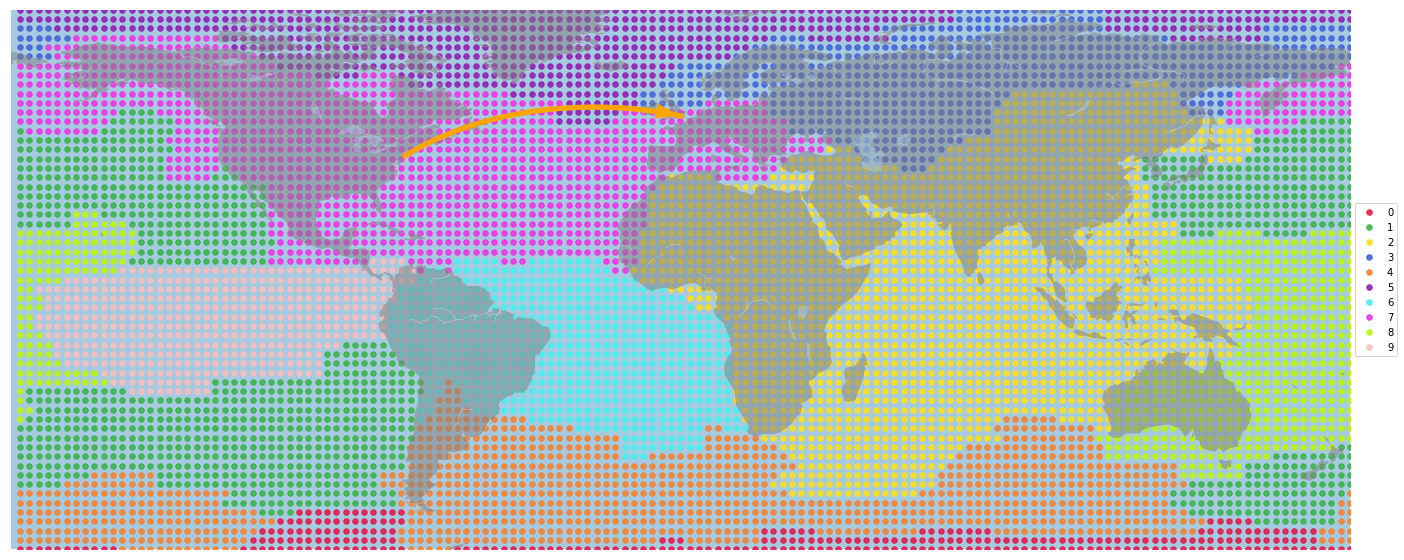

In [82]:

df_list = []
for j in range(n_components_pres):
    df_list.append(pd.DataFrame(columns=df_pres.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_pres)

for i in range(n_components_pres):
    values = df_pres["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_pres.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
m.drawgreatcircle(nylon,nylat,lonlon,lonlat, linewidth=5, color='orange')

# grab the great circle, assign a variable for it
gcline, = m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=5,color='orange')
path = gcline.get_path()  # get path from the great circle

head = m(lonlon,lonlat)             # get location of arrow's head (at London)
tail = path.vertices[-2]  # get location of arrow's tail
ax.annotate('',
            xy=(head[0], head[1]), 
            xycoords='data',
            xytext=(tail[0], tail[1]), 
            textcoords='data',
            size=22,
            arrowprops=dict(headwidth=15, \
                            headlength=25, \
                            facecolor="orange", \
                            edgecolor="none", \
                            connectionstyle="arc3, rad=0.001") )

#plt.legend()
plt.show()

In [36]:
path.vertices[-3]

array([-2.63287493, 52.05938162])

# Adding Air temperature (PCA)

In [24]:
air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))
data_air = pd.DataFrame(result_air)

#result_air = pf.deseasonalize(np.array(result_air))
n_components_air = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_air)

pca = PCA(n_components=n_components_air)
pca_model = pca.fit(scaled_data)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_air = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_air = pd.DataFrame(Matrix)

clusters = loading_air.idxmax(axis=1)
df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clusters.values.tolist()})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

# Adding Air temperature (Clustering)

In [40]:
n_components_air = 10

air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_air)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_air).fit(np.transpose(temp))

df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clustering.labels_})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

cluster_air = []
for i in range(n_components_air):
    Idx = np.where((df_air.clusters == i).values)[0]
    r = result_air[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_air)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_air.append(pca_data[:,0])

df_cluster_air = pd.DataFrame(np.transpose(np.matrix(cluster_air)))

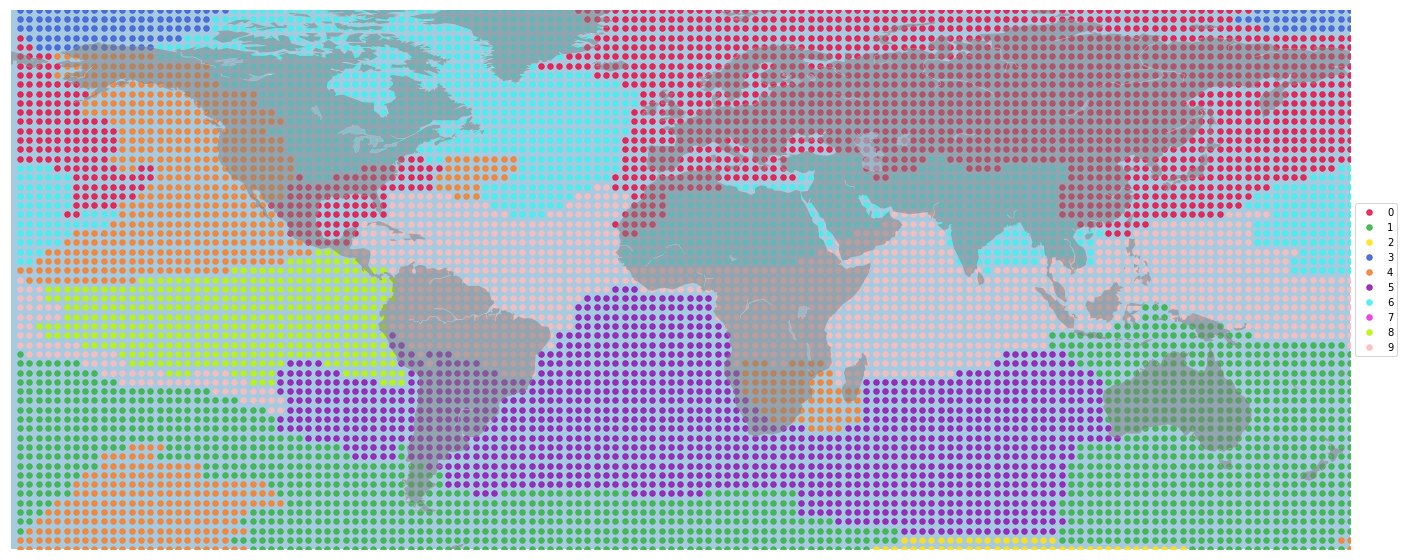

In [45]:
df_list = []
for j in range(n_components_air):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_air)

for i in range(n_components_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

# Discovery of Causality links

In [254]:
d_name  = ["d"]


pres_name  = []
for i in range(n_components_pres):
    pres_name.append("Pres_%d"%i)

#air_name  = []
#for i in range(n_components_air):
#    air_name.append("Air_%d"%i)

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

precip_name  = []
for i in range(n_components):
    precip_name.append("Precipitation_%d"%i)
#
var_names = d_name + precip_name + air_name + sst_name +  pres_name

result_d = np.matrix(d)
result_precip = np.matrix(df_cluster)
#result_sst = result_sst.dot(loading_sst)
#result_air = result_air.dot(loading_air)
#result_pres = result_pres.dot(loading_pres)

result_air = np.matrix(df_cluster_air)
result_sst = np.matrix(df_cluster_sst)
result_pres = np.matrix(df_cluster_pres)


result = np.concatenate((result_d, result_precip, result_air, result_sst, result_pres), axis=1)
result = np.matrix(result)

In [278]:
result = pd.DataFrame(result)

In [279]:
result.to_csv("df_cluster.csv")

In [255]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [256]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [257]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable d has 7 link(s):
        (Precipitation_0 0): pval = 0.00000 | val = 0.242
        (Precipitation_4 0): pval = 0.00000 | val = 0.173
        (Precipitation_3 0): pval = 0.00001 | val = 0.157
        (SST_9 -2): pval = 0.00292 | val = 0.105
        (SST_5 -2): pval = 0.00387 | val = 0.103
        (SST_2 0): pval = 0.00850 | val = 0.093
        (SST_9 0): pval = 0.00955 | val = -0.092

    Variable Precipitation_0 has 11 link(s):
        (Pres_4 0): pval = 0.00000 | val = 0.253
        (d 0): pval = 0.00000 | val = 0.242
        (Pres_7 0): pval = 0.00000 | val = 0.235
        (Precipitation_0 -1): pval = 0.00000 | val = 0.168
        (SST_1 0): pval = 0.00001 | val = -0.158
        (Pres_9 0): pval = 0.00039 | val = -0.127
        (Air_1 0): pval = 0.00040 | val = 0.126
        (SST_0 0): pval = 0.00115 | val = 0.116
        (Pres_6 0): pval = 0.00175 | val = 0.112
        (SST_4 -1): pval = 0.00579 | val = -0.098
        (Pres_3 -1):

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07ae76d128>)

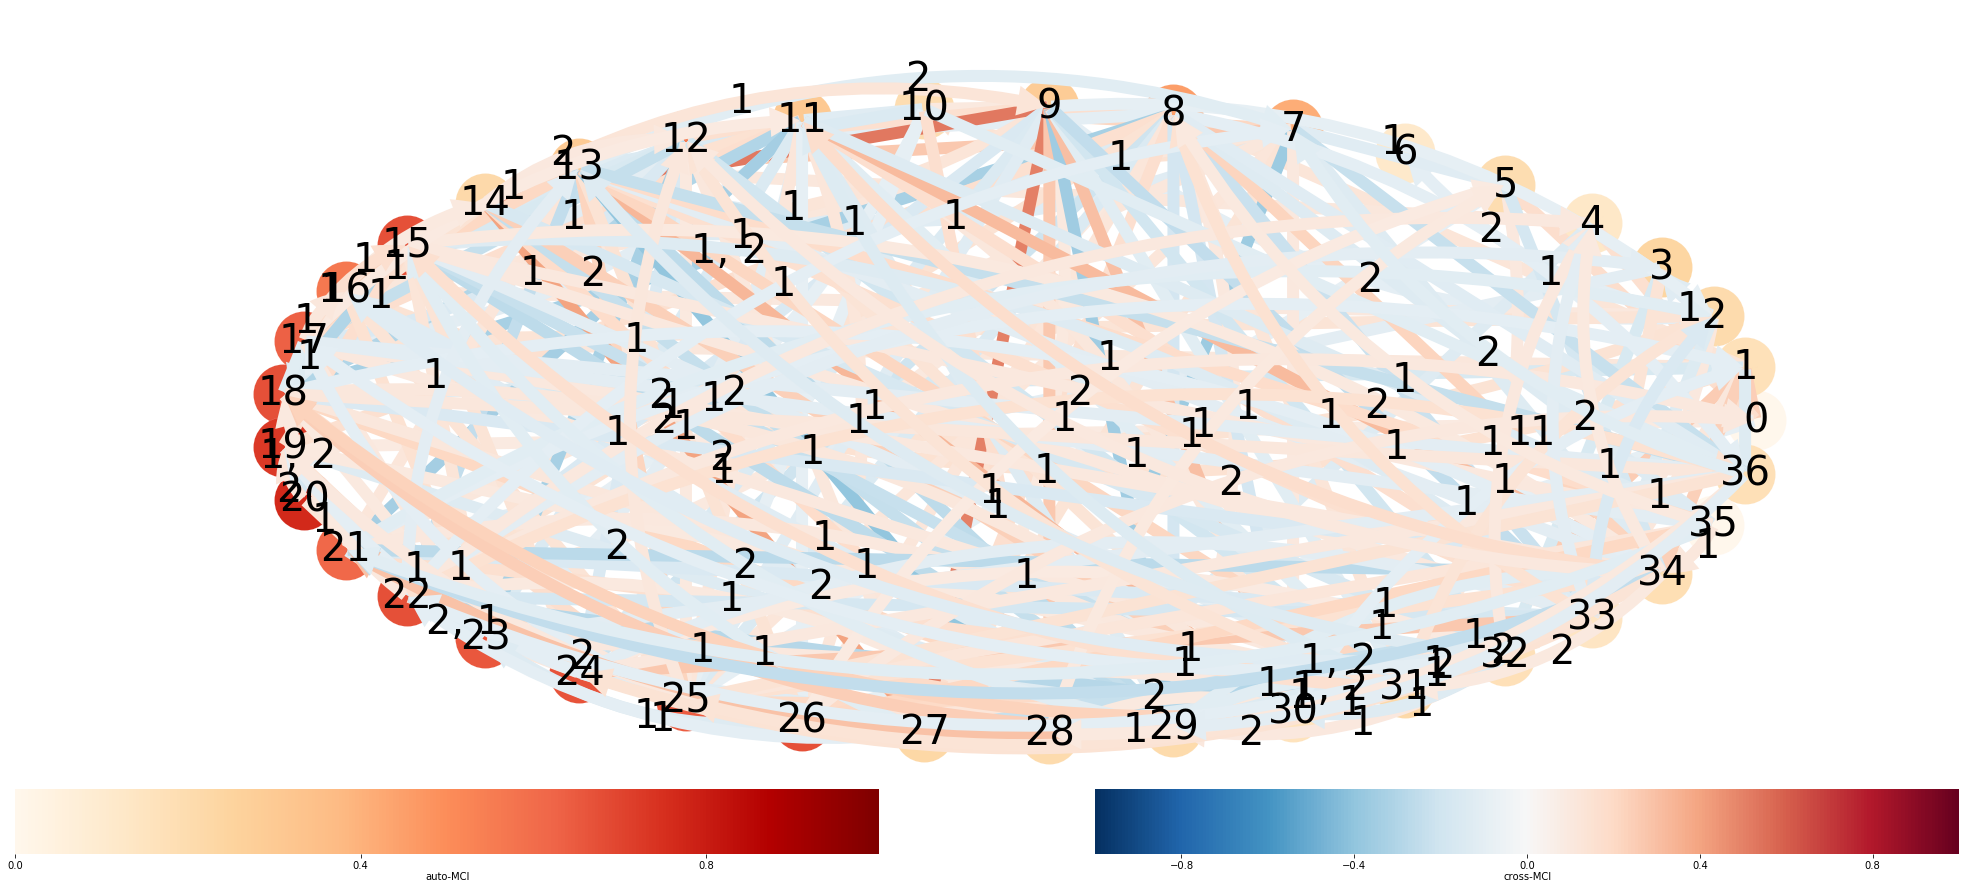

In [258]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

In [259]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable d has 5 link(s):
        (Precipitation_0 0): pval = 0.00000 | qval = 0.00000 | val = 0.242
        (Precipitation_4 0): pval = 0.00000 | qval = 0.00000 | val = 0.173
        (Precipitation_3 0): pval = 0.00001 | qval = 0.00001 | val = 0.157
        (SST_2 0): pval = 0.00850 | qval = 0.00850 | val = 0.093
        (SST_9 0): pval = 0.00955 | qval = 0.00955 | val = -0.092

    Variable Precipitation_0 has 9 link(s):
        (Pres_4 0): pval = 0.00000 | qval = 0.00000 | val = 0.253
        (d 0): pval = 0.00000 | qval = 0.00000 | val = 0.242
        (Pres_7 0): pval = 0.00000 | qval = 0.00000 | val = 0.235
        (Precipitation_0 -1): pval = 0.00000 | qval = 0.00017 | val = 0.168
        (SST_1 0): pval = 0.00001 | qval = 0.00001 | val = -0.158
        (Pres_9 0): pval = 0.00039 | qval = 0.00039 | val = -0.127
        (Air_1 0): pval = 0.00040 | qval = 0.00040 | val = 0.126
        (SST_0 0): pval = 0.00115 | qval = 0.00115 | val = 0.1

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f07adff0320>)

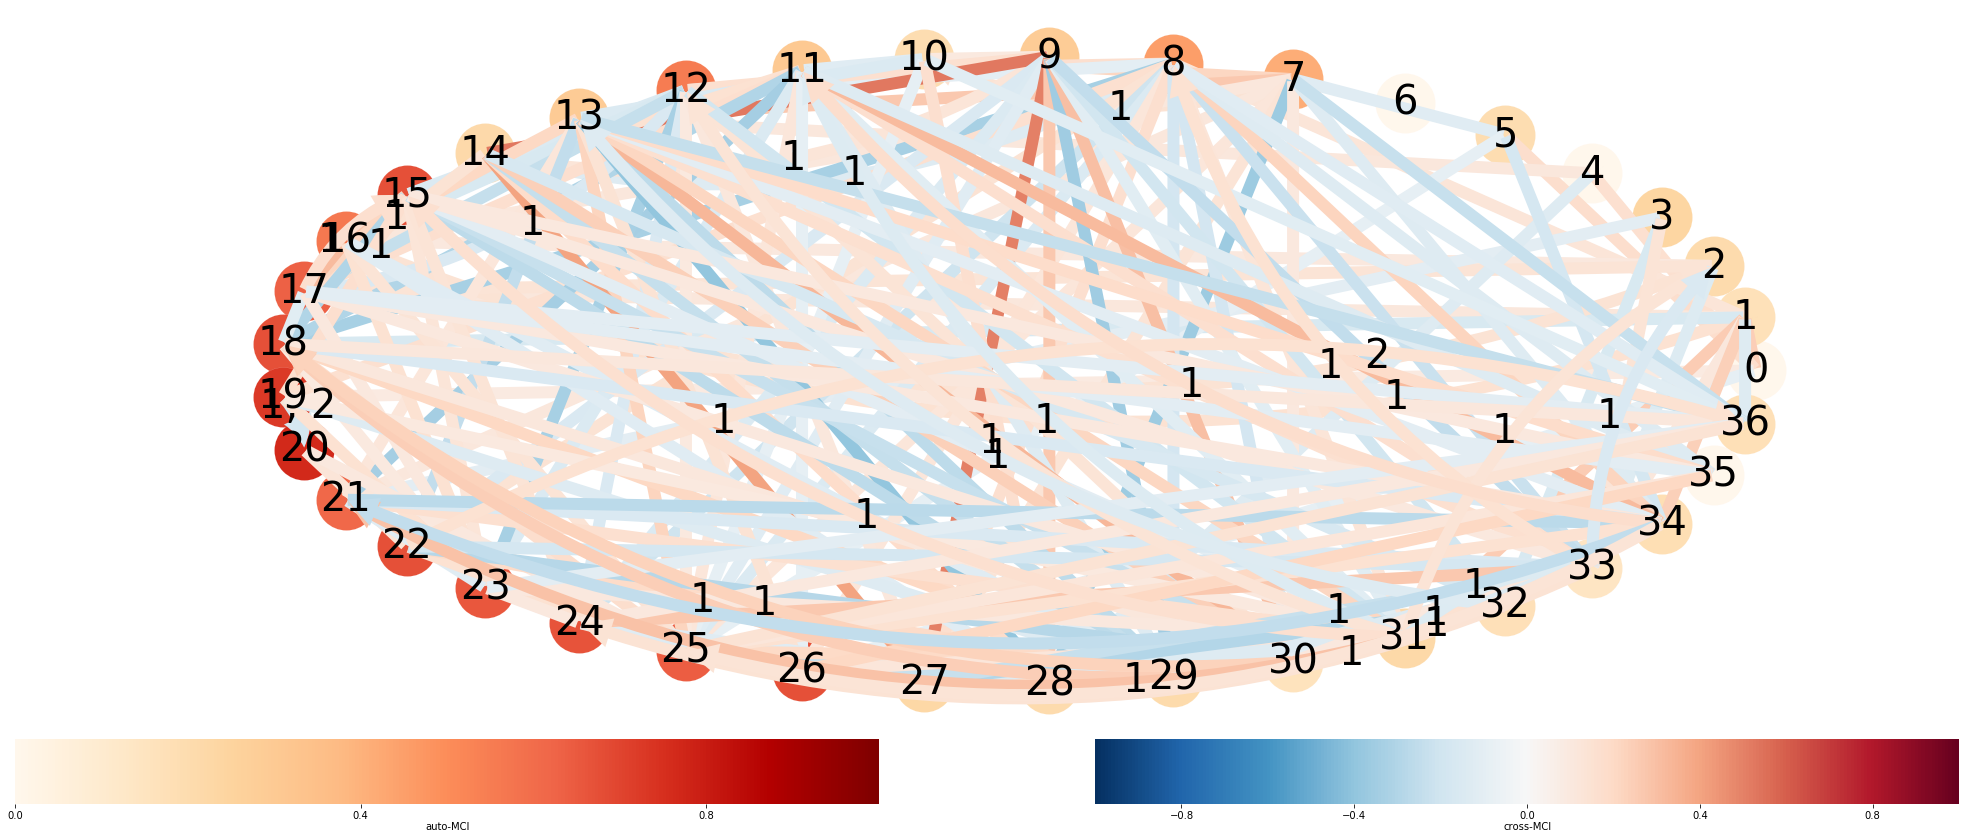

In [260]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

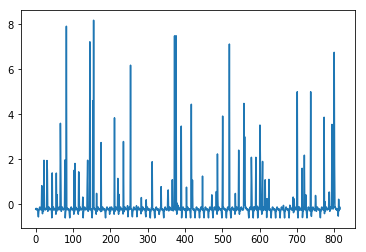

In [154]:
plt.plot(d)

In [261]:
scale = StandardScaler()
scaled_data = scale.fit_transform(df_cluster_sst)

array([ 1.35087618e+00,  9.07762554e-01,  1.08787461e+00,  1.44237027e+00,
        1.28830903e+00,  7.09847167e-01,  1.23574371e+00,  1.81445193e+00,
        1.66283259e+00,  1.23797595e+00,  1.27196625e+00,  1.17149567e+00,
        1.07350674e+00,  1.28615782e+00,  1.15023921e+00,  1.51488164e+00,
        1.60503062e+00,  1.48750566e+00,  7.12722697e-01,  1.17569838e+00,
        1.20040864e+00,  8.74323882e-01,  1.44880158e+00,  1.29539217e+00,
        1.18087359e+00,  1.39467075e+00,  1.17538611e+00,  1.00867497e+00,
        7.39767981e-01,  4.13340690e-01,  5.39400418e-01,  3.86928349e-01,
        3.05440510e-01,  9.83065444e-01,  1.53502206e+00,  1.24919207e+00,
        1.19542623e+00,  1.28364029e+00,  1.41713526e+00,  1.50551179e+00,
        1.44148227e+00,  1.50348930e+00,  1.42020229e+00,  1.49339406e+00,
        9.98467538e-01,  1.31601380e+00,  1.79201369e+00,  1.90803215e+00,
        1.55100730e+00,  1.30695799e+00,  1.13694855e+00,  1.19506005e+00,
        1.43083963e+00,  

In [268]:
d = pd.DataFrame(d)

In [272]:
d[0]

0     -0.209636
1     -0.182363
2     -0.253945
3     -0.218395
4     -0.196545
         ...   
812    0.221972
813   -0.291036
814   -0.149598
815   -0.122169
816   -0.209636
Name: 0, Length: 817, dtype: float64

In [274]:
x = range(50)

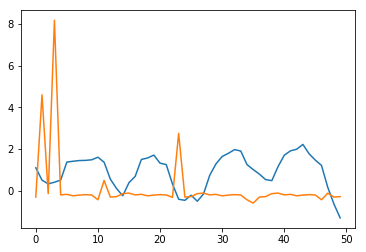

In [285]:
plt.plot(x,scaled_data[150:200,2],x,d[0].values[152:202])

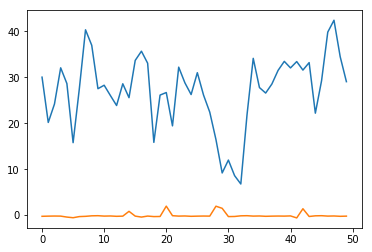

In [181]:
plt.plot(x,df_cluster_sst[0].values[:50],x,d[360].values[2:52])

In [231]:
result.shape

(817, 37)

In [281]:
result.shape

(817, 37)

In [299]:
result[0]

0     -0.209636
1     -0.182363
2     -0.253945
3     -0.218395
4     -0.196545
         ...   
812    0.221972
813   -0.291036
814   -0.149598
815   -0.122169
816   -0.209636
Name: 0, Length: 817, dtype: float64

In [300]:
dataframe = pd.concat([result[0].shift(1), result[0]], axis=1)

In [302]:
dataframe = pd.concat([result[0].shift(3), dataframe], axis=1)

In [303]:
dataframe

,0,0,0,0
0,NaN,NaN,NaN,-0.209636
1,NaN,NaN,-0.209636,-0.182363
2,NaN,-0.209636,-0.182363,-0.253945
3,-0.209636,-0.182363,-0.253945,-0.218395
4,-0.182363,-0.253945,-0.218395,-0.196545
...,...,...,...,...
812,-0.213476,-0.443187,-0.528254,0.221972
813,-0.443187,-0.528254,0.221972,-0.291036
814,-0.528254,0.221972,-0.291036,-0.149598
815,0.221972,-0.291036,-0.149598,-0.122169
